# Data preparation 

Prepare Stanford Cars dataset

In [1]:
# import packages 
import torch 
import torchvision
import kagglehub

/Users/ball/Documents/workspace/diffusion/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device configuration 

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA as device")
else:
    # Check that MPS is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device("cpu")
        print("Using CPU as device")
    else:
        device = torch.device("mps")
        print("Using MPS as device")
    
torch.set_default_device(device)

Using MPS as device


In [3]:
# Define Dataloader for Stanford Cars dataset 
import torch.utils.data as data 
import os 
from typing import Literal
from PIL import Image

class CarsDataset(data.Dataset): 
    def __init__(self, opt: Literal['test', 'train'], transform = None): 
        super(CarsDataset, self).__init__()
        
        path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

        self.test_path = f'{path}/cars_test/cars_test/'
        self.train_path = f'{path}/cars_train/cars_train/'

        # set if the dataset is for train or test 
        self.opt = opt 
        self.transform = transform 

        if opt == 'test':
            self.path = self.test_path 
        else:
            self.path = self.train_path 
        self.cnt = None 

    def __getitem__(self, idx): 
        idx = idx + 1
        total = self.__len__()

        # handle out of index 
        if idx <= 0 or idx > total:
            raise Exception("Invalid idx access to dataset")
            return None 

        # get image of name with idx
        file_name = f'{idx:05}.jpg'
        image = Image.open(os.path.join(self.path, file_name))

        if self.transform: 
            image = self.transform(image)

        return image 
    def __len__(self): 
        # count the numbers of image in the test or train directory
        if self.cnt != None:
            return self.cnt 
        
        cnt = 0
        for file in os.listdir(self.path): 
            if os.path.isfile(os.path.join(self.train_path, file)): 
                cnt += 1
        self.cnt = cnt 
        return cnt 

In [4]:
# Set training Configuration 
BATCH_SIZE = 128
INIT_LR = 1e-3
IMG_SIZE = 64
EPOCHS = 300

In [5]:
# Make Dataloader 
from torch.utils.data import DataLoader
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(), 
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(), # scales the data into [0, 1]
    transforms.Lambda(lambda t: (t * 2) - 1) # scale between [-1, 1]
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t+1) / 2), 
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: t * 255.), 
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), 
    transforms.ToPILImage(),
])

# define datasets 
train_data = CarsDataset('train', transform=data_transform)
test_data = CarsDataset('test', transform=data_transform)

# concat dataset because no need for test data in Diffusion model 
train_data = train_data + test_data

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True, generator= torch.Generator(device=device), drop_last=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False, generator= torch.Generator(device=device), drop_last=True)

# Implement the Forward process of Diffusion Model 

In [6]:
import torch.nn.functional as F 

# generate beta_t for each timesteps 
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):  
    return torch.linspace(start, end, timesteps)

# returns the specific index t 
def get_index_from_list(vals, t, x_shape): 
    batch_size = t.shape[0]
    out = vals.gather(-1, t.to(device))
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# take image x_0 as input, and return noisy version of it 
def forward_diffusion_sample(x_0, t):
    
    noise = torch.randn_like(x_0) 

    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    # return mean + variance * noise, noise 
    
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    

# Define beta schedule 
T = 100 
betas = linear_beta_schedule(timesteps=T)

# pre-calculate different terms for closed form 
alphas = 1. - betas 
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas_cumprod)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

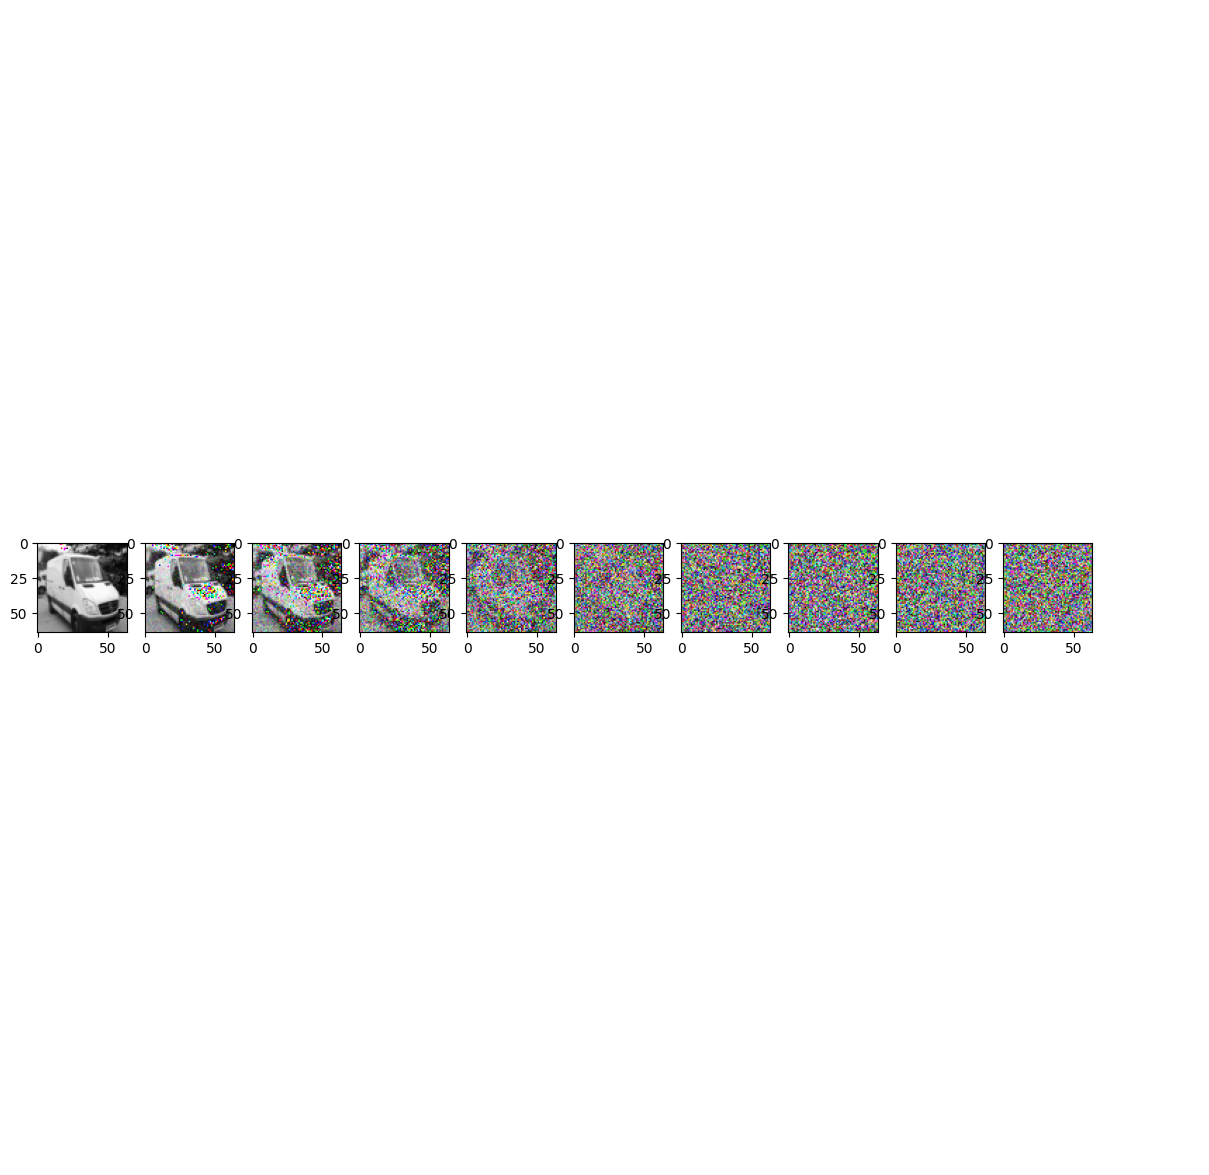

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 

# define function show_tensor_image 
def show_tensor_image(image): 
    if len(image.shape) == 4: 
        image = image[0, :, :, :] 
    plt.imshow(reverse_transform(image))


# Iterate noising process over one image 
image = next(iter(train_dataloader))[0]

plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for idx in range(0, T, stepsize): 
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, (idx // stepsize) + 1) 
    image, noise = forward_diffusion_sample(image, t) 
    show_tensor_image(image)
    

# Implement Backward Process using U-Net

In [8]:
from torch import nn 
import math 

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [9]:


class SinusoidalPositionEmbeddings(nn.Module): 
    def __init__(self, dim): 
        super().__init__() 
        self.dim = dim 

    def forward(self, time): 
        device = time.device 
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1) 
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings
        

In [10]:
class SimpleUnet(nn.Module): 
    def __init__(self): 
        super().__init__()
        image_channels = 3 
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32 

        # Time embedding 
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim), 
            nn.Linear(time_emb_dim, time_emb_dim), 
            nn.ReLU()
        )

        # Initial projection 
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)

        # Downsample 
        self.down_samples = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels) - 1)])

        # Upsample 
        self.up_samples = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])

        # match the final output dimension 
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1) 

    def forward(self, x, timestep): 
        h = x.to(device)
        t = timestep.to(device)
        # embed time 
        t = self.time_mlp(timestep)

        # push image to initial projection(conv0)
        h = self.conv0(h)

        # apply unet 
        residual_inputs = [] 

        for down in self.down_samples: 
            h = down(h, t)
            residual_inputs.append(h)

        for up in self.up_samples: 
            residual_h = residual_inputs.pop()

            h = torch.cat((h, residual_h), dim=1)
            h = up(h, t)

        return self.output(h)

In [11]:
# Define a Unet model 
model = SimpleUnet() 
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
model 

Number of parameters: 62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_samples): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (t

In [12]:
# Define a loss function for training 
mseloss = nn.MSELoss()
def get_loss(model, x_0s, t): 
    x_noisy, noise = forward_diffusion_sample(x_0s, t) 
    noise_pred = model(x_noisy, t) 
    return mseloss(noise, noise_pred)
    

In [13]:
# Sample one image a.k.a generate one image using Diffusion model 

# get image from specific timestep from (timestep+1) image
@torch.no_grad()
def sample_timestep(x, t): 
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    # print(f'model_mean: {model_mean}')

    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0: 
        return model_mean 
    else: 
        noise = torch.rand_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(): 
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images=10 
    stepsize=int(T/num_images)

    for i in range(0, T)[::-1]: 
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t) 
        img = torch.clamp(img, -1.0, 1.0)

        if i % stepsize == 0: 
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()
    
    

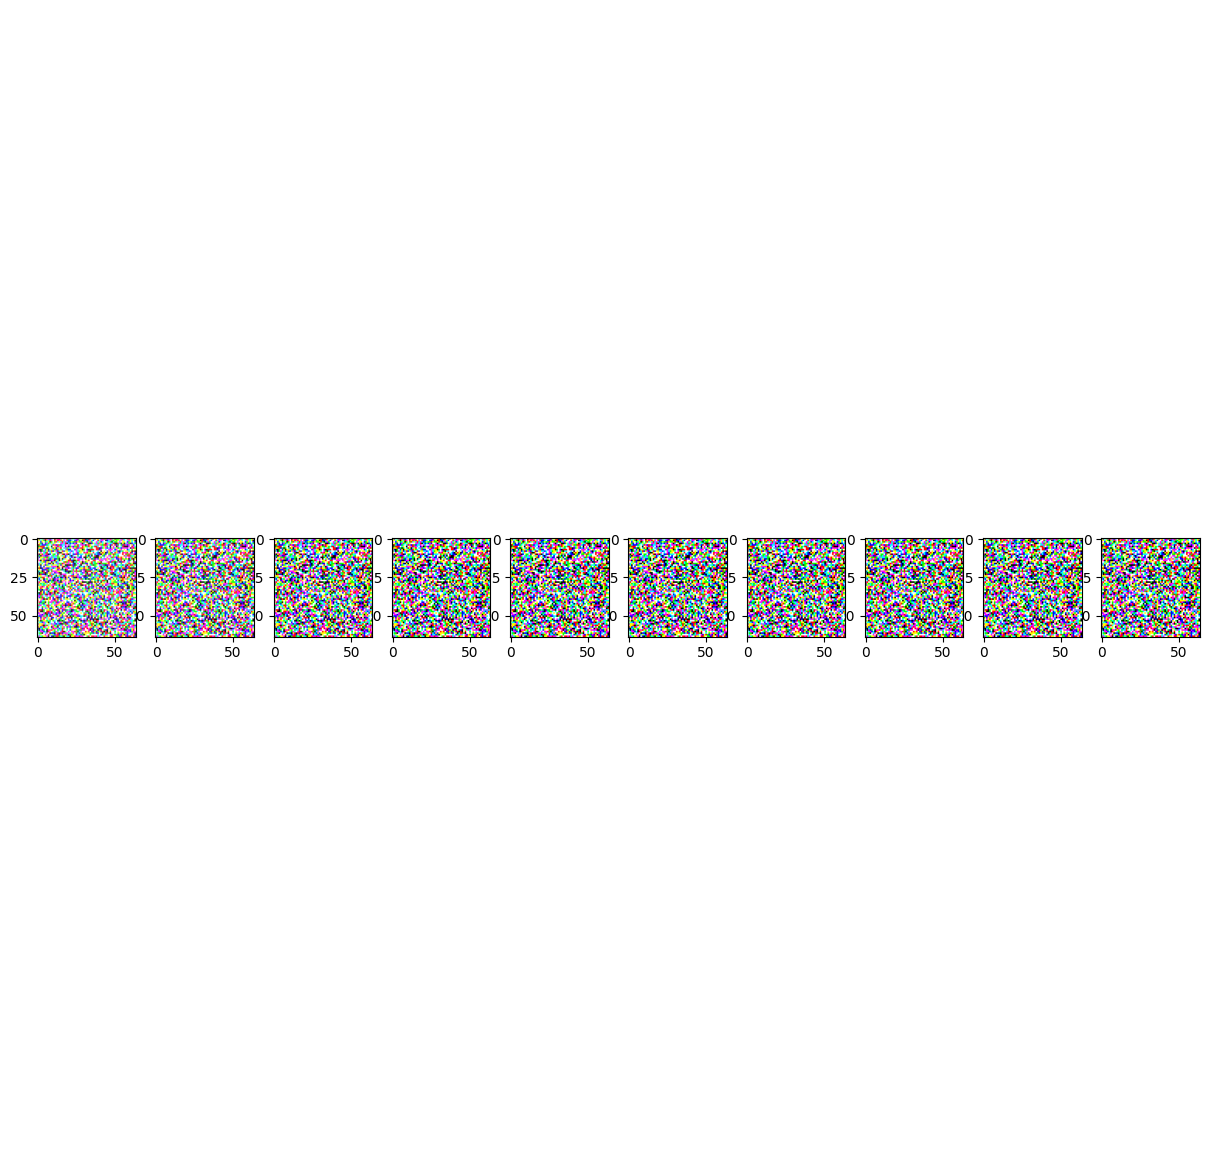

In [14]:
sample_plot_image()

0it [00:00, ?it/s]

Epoch 0, Step 0 | Last Loss: 1.0298700332641602


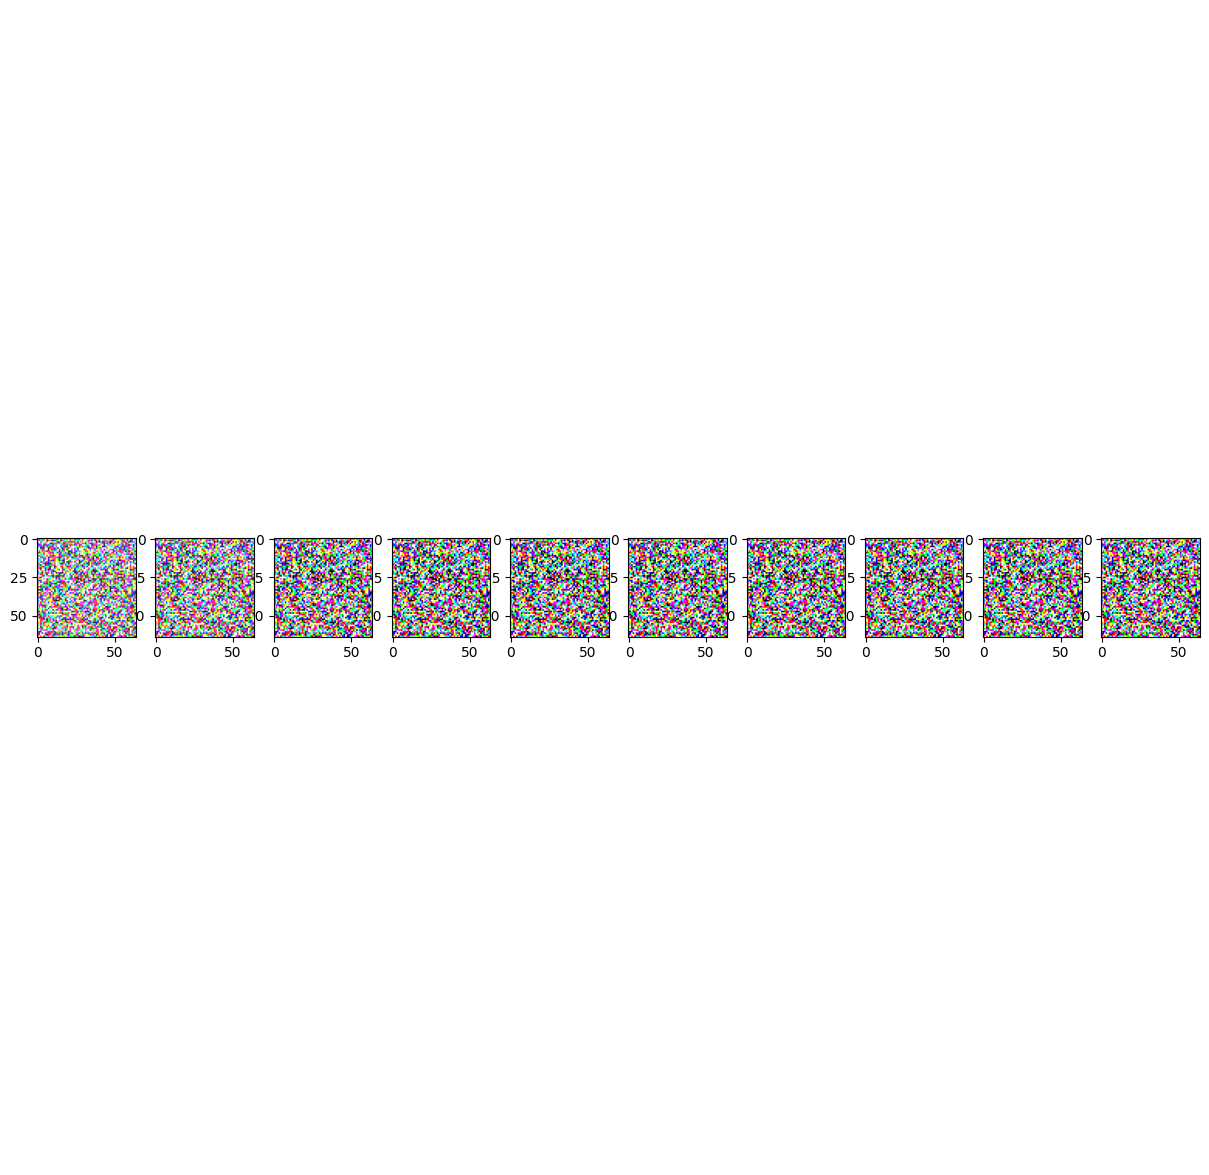

6it [00:30,  5.11s/it]


KeyboardInterrupt: 

In [15]:
# train the model 
from datetime import datetime
from torch.optim import Adam 
from tqdm import tqdm

model.to(device)
optimizer = Adam(model.parameters(), INIT_LR)
best_avg_loss = 100_000_000

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# go through one epoch 
def train_epoch(epoch_num):
    loss_sum = 0. 
    last_loss = 0.
    for step, batch in tqdm(enumerate(train_dataloader)): 
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch, t)
        loss.backward() 
        loss_sum += loss.item()
        last_loss = loss.item()
        optimizer.step()

        if step % 50 == 0: 
            print(f'Epoch {epoch_num}, Step {step} | Last Loss: {last_loss}')
            sample_plot_image()

    avg_loss = loss_sum / (step + 1)
    print(f'@@ Epoch {epoch_num} | Average Loss: {avg_loss} | Last Loss: {last_loss}')

    if best_avg_loss > avg_loss: 
        best_avg_loss = avg_loss
        model_path = f'models/model_{timestamp}_{epoch_num}'
        torch.save(model.state_dict(), model_path)
    
    
    # show sample plot image 
    sample_plot_image()
        
for epoch in range(EPOCHS): 
    train_epoch(epoch)
    
